<a href="https://colab.research.google.com/github/ankit-rathi/Quantvesting_v2/blob/main/mySector_Indices_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2025-02-28 19:20:12


In [2]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=6d31204d806575aef1d9c3c120d996203b988125cf4bfd37b151ae7cf6b75eb6
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta


In [3]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
import pandas_ta as ta

from google.colab import data_table

In [4]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-366)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

In [5]:
# fetch nse indices scrips

import pandas as pd
import numpy as np

df_nse_sectors = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/NSE_Sectors_Indices.csv')

In [6]:
sectors = df_nse_sectors['Sector'].unique()
#print(sectors)
#sectors = ['BANKS', 'IT']
df_sectors = pd.DataFrame()
for sector in sectors:
  stocks = df_nse_sectors[df_nse_sectors['Sector'] == sector]['Symbol'].values
  df_sector = pd.DataFrame()
  tweight = 0
  for stock in stocks:
    stock_df = yfin.Ticker(stock+'.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    col = ['Close']
    stock_df = stock_df[col]
    stock_df['Split'] = 1
    weight = df_nse_sectors[df_nse_sectors['Symbol'] == stock]['Weight'].values[0]
    tweight = sum(df_nse_sectors[df_nse_sectors['Sector'] == sector]['Weight'].values)
    if stock == 'NESTLEIND':
      stock_df.loc[stock_df.index < '2024-01-01', 'Split'] = 10
    #stock_df[stock] = (stock_df[col]*weight)/(tweight*stock_df['Split'].values[0])
    stock_df[stock] = stock_df['Close']/stock_df['Split']
    col = [stock]
    stock_df = stock_df[col]
    df_sector = pd.concat([df_sector, stock_df], axis=1)

  df_sector[sector] = df_sector[stocks].sum(axis=1)
  col = [sector]
  df_sector = df_sector[col]
  df_sectors = pd.concat([df_sectors, df_sector], axis=1)
sector_df_full = df_sectors

In [7]:
def stock_prec_dev(stock_symbol):
    #print(stock_symbol)
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = df_sectors[[stock_symbol]]
    stock_df.columns = ['Close']

    #stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df['Max']  = round(stock_df['Close'].dropna().max(), 2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Sector'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)

    #stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df['Min']  = round(stock_df['Close'].dropna().min(), 2)
    #stock_df['Gained%'] = round((stock_df['Close'] - stock_df['Min'])*100/stock_df['Min'],2)
    stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    #stock_df['Close'] = round(stock_df['Close'],0)
    stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
    stock_df['ATH%'] = round((stock_df['Max'] - stock_df['Close'])*100/stock_df['Close'],2)
    #stock_df['Sector'] = stock_symbol
    stock_df = stock_df.tail(1)
    return stock_df

In [8]:
df_final =  pd.DataFrame()
for sector in sectors:

  df_tmp = stock_prec_dev(sector)
  df_final = pd.concat([df_final, df_tmp], ignore_index = True) #df_final.append(df_tmp)
# all sectors
df_final = df_final.sort_values(by = 'ATH%', ascending=False)
#data_table.DataTable(df_final, include_index=False)
df_final

,Close,Max,200_SMA,Dev%_200,Sector,Min,RSI_14,ATH%
13,2337.28,4283.22,2943.0,-20.58,TEXTILES,1770.82,43.0,83.26
6,2556.73,3815.05,3237.0,-21.02,MEDIA,1285.62,43.0,49.22
11,29781.20,41786.29,31555.0,-5.62,DURABLES,18006.56,40.0,40.31
15,1529.37,2121.58,1796.0,-14.85,SUGAR,519.69,44.0,38.72
14,3630.80,4910.38,4229.0,-14.15,FOOTWEAR,556.25,48.0,35.24
7,5123.14,6896.25,5971.0,-14.20,METAL,4363.57,45.0,34.61
0,30086.55,39099.88,32838.0,-8.38,AUTO,15494.00,47.0,29.96
4,11163.85,14354.27,12415.0,-10.08,FMCG,6905.05,48.0,28.58
12,4084.83,5183.23,4539.0,-10.01,JEWELLERY,691.02,48.0,26.89
3,13767.40,17239.93,15176.0,-9.28,IT,12342.52,32.0,25.22


<Axes: xlabel='Date'>

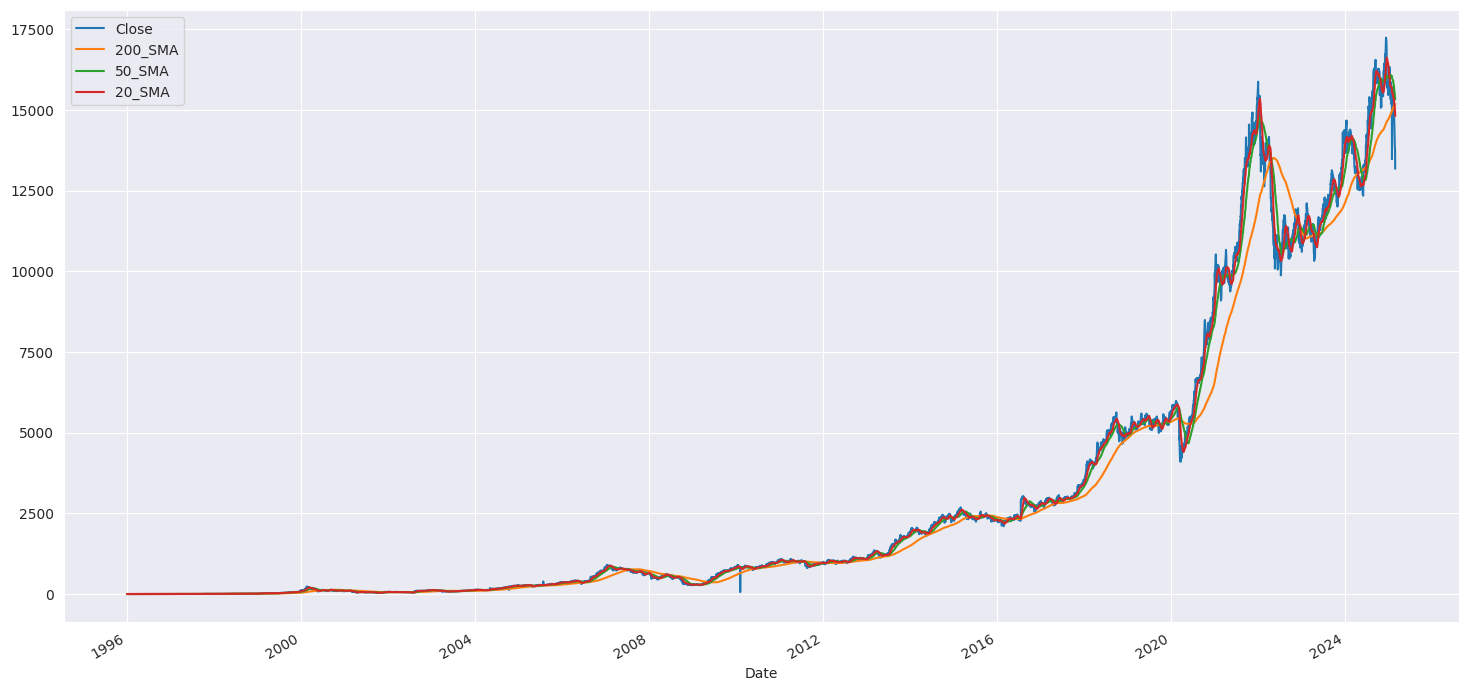

In [9]:
col = ['IT']
sector_df = sector_df_full[col]
sector_df.columns = ['Close']
sector_df['200_SMA'] = round(sector_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
sector_df['50_SMA'] = round(sector_df['Close'].rolling(window = 50, min_periods = 1).mean(),0)
sector_df['20_SMA'] = round(sector_df['Close'].rolling(window = 20, min_periods = 1).mean(),0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = sector_df.reset_index()
tmp_df.plot(x='Date', y=['Close','200_SMA','50_SMA','20_SMA'], figsize=(18,9))

In [10]:
df_sectors = df_sectors[(df_sectors.index <= end_date) & (df_sectors.index >= start_date)]
for sector in sectors:
  base_value = df_sectors[sector].head(1).values[0]
  df_sectors[sector] = df_sectors[sector]*100/base_value

df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR,SUGAR
Date,,,,,,,,,,,,,,,,
2024-02-28 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2024-02-29 00:00:00+05:30,99.909071,100.207678,100.351159,99.092322,100.983101,100.260806,99.932273,101.648354,99.448803,99.588492,100.162602,100.478611,100.963056,103.386868,100.340860,100.213830
2024-03-01 00:00:00+05:30,102.405979,102.650199,101.781041,98.616200,100.842472,99.678663,100.438699,104.185446,101.248032,100.750097,101.356613,101.560072,104.227682,103.317947,101.311769,99.209888
2024-03-04 00:00:00+05:30,103.071840,102.940640,102.348359,98.023746,100.172721,100.854458,100.822226,104.472566,100.796100,98.792358,101.127668,104.381886,103.880940,100.891025,100.597725,101.631025
2024-03-05 00:00:00+05:30,104.127080,102.907628,98.569271,96.533518,99.228246,100.799489,100.527686,104.074965,100.370509,99.880742,98.854225,103.930373,104.176323,100.508155,101.455698,101.049691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-20 00:00:00+05:30,109.144466,112.538913,123.145474,103.664541,94.144960,126.632546,89.081731,93.042335,106.001653,104.737765,108.710273,162.404150,87.927857,85.878444,88.738788,114.392766
2025-02-21 00:00:00+05:30,107.101741,111.777042,122.996886,102.940017,94.182898,123.524885,88.819084,92.653670,105.158036,104.868496,108.047695,162.629701,87.382326,86.322570,89.109208,114.156131
2025-02-24 00:00:00+05:30,107.339239,111.414284,122.040895,99.290173,94.177417,122.934065,88.276057,91.213491,103.863260,105.626592,107.362731,162.834615,86.765299,86.220755,88.692332,113.922341


In [11]:
cols = df_sectors.columns
for col in cols:
  median = df_sectors.loc[df_sectors[col]< 90, col].median()
  df_sectors.loc[df_sectors[col] < 90, col] = np.nan
  df_sectors[col] = np.where(df_sectors[col] < 90, median,df_sectors[col])

<Axes: xlabel='Date'>

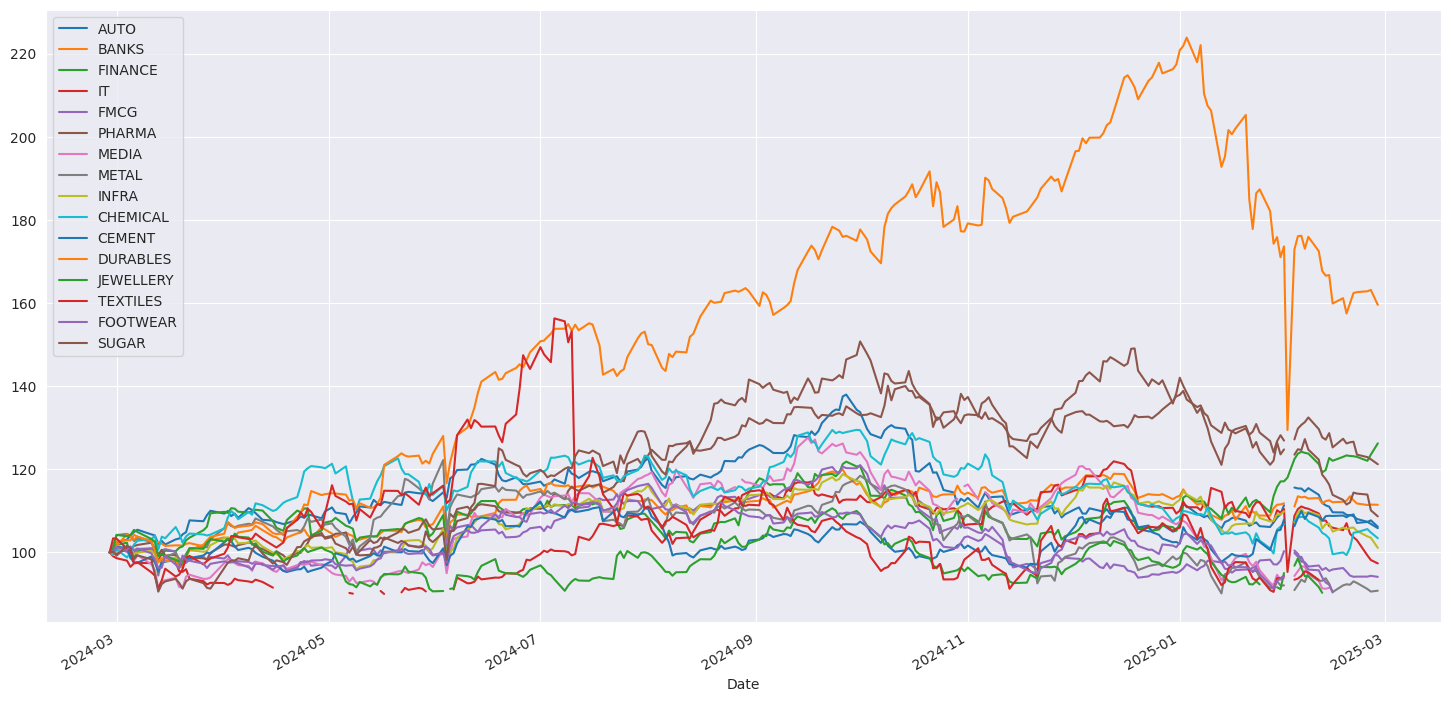

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = df_sectors.reset_index()
tmp_df.plot(x='Date', y=sectors, figsize=(18,9))

In [13]:
df_tmp = df_sectors.tail(1).T
df_tmp.columns = ['Close']
df_tmp.sort_values(by = 'Close', ascending=False)

,Close
DURABLES,159.549463
FINANCE,126.244343
PHARMA,121.225713
BANKS,111.470094
SUGAR,108.678065
AUTO,106.173452
CEMENT,105.842243
CHEMICAL,103.421326
INFRA,101.097966
IT,97.362706
